<a href="https://colab.research.google.com/github/jbzt/TCGA_PRAD_biotrain/blob/main/classification_in_TCGA_PRAD_with_links.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre Actividad
antes de empezar correr este chunk de codigo para darle tiempo a cargar todas los paquetes y archivos necesarios



In [ ]:
# Create a directory to store the data if it doesn't already exist
if (!dir.exists("datos.prad")) {
  dir.create("datos.prad")
}

# Define the local file path
local_path <- "datos.prad/gene.expression.RDS"
# (Optional) Download the data if the local file is not found
 if (!file.exists(local_path)) {
   options(timeout = max(1200, getOption("timeout"))) # Increase timeout for large files
   dropbox_url <- "https://www.dropbox.com/scl/fi/uje2isrxl8ojoaoziaolh/gene.expression.RDS?rlkey=sk4kys0zxmrzou8jccts76n4r&st=v8l1iu62&dl=1"
   download.file(url = dropbox_url, destfile = local_path, mode = "wb")
 }

# Define the local file path
local_path <- "datos.prad/pheno.data.RDS"
# (Optional) Download the data if the local file is not found
 if (!file.exists(local_path)) {
   options(timeout = max(1200, getOption("timeout"))) # Increase timeout for large files
   dropbox_url <- "https://www.dropbox.com/scl/fi/2xac199unkqn82qnuvb54/pheno.data.RDS?rlkey=fw3bg37x5mnybz732rymy5iz3&st=e2y7qcgp&dl=1"
   download.file(url = dropbox_url, destfile = local_path, mode = "wb")
 }

# Define the local file path
local_path <- "datos.prad/top_var_genes.RDS"
# (Optional) Download the data if the local file is not found
 if (!file.exists(local_path)) {
   options(timeout = max(1200, getOption("timeout"))) # Increase timeout for large files
   dropbox_url <- "https://www.dropbox.com/scl/fi/l90rwc3mdcwldlsjuq6i5/top_var_genes.RDS?rlkey=idz9js5kws52yadzsut8l2qag&st=ujtti72b&dl=1"
   download.file(url = dropbox_url, destfile = local_path, mode = "wb")
 }


 # PASO 1: DESCARGAR TODO DESDE LOS ENLACES PÚBLICOS
cat("Descargando paquetes y datos. Esto puede tardar un momento...\n")

download.file("https://www.dropbox.com/scl/fi/6ezzngmq177iiis0gpc75/R_packages_JB.zip?rlkey=irdxymfa9wtezg31izfe0xxy3&st=f5vhpeuh&dl=1",
destfile = "R_packages_JB.zip",
mode = "wb")

# PASO 2: CONFIGURAR LOS PAQUETES (igual que antes)
unzip("R_packages_JB.zip")
.libPaths(new = c("R_libs_temp_JB", .libPaths()))

# otros paquetes
install.packages("kernlab")
install.packages("randomForest")


# PASO 3: CARGAR LAS LIBRERÍAS NECESARIAS PARA ESTE SCRIPT
library(tidyverse)
library(Rtsne)
library(plotly)
library(vegan)
library(cluster)
library(pheatmap)
library(stats)
library(caret)
library(ROCR)
library(ggfortify)
library(gtsummary)
library(glmnet)
library(xgboost)
library(mclust)
library(survival)
library(survminer)
library(readxl)

cat("Configuración completa. Todos los paquetes han sido cargados desde Google Drive.\n")

options(repr.plot.width = 14, repr.plot.height = 7)

<style>
body {
text-align: justify;
}
</style>

# Introduction

This document outlines a complete machine learning workflow for building and evaluating predictive models based on gene expression data. The primary objective is to classify patient samples into distinct clinical outcome groups—in this case, predicting disease recurrence within three years.

The analysis is structured into four main parts:
1.  **Exploratory Data Analysis (EDA):** We begin by loading and inspecting the gene expression and clinical (phenotypic) datasets. We use unsupervised methods like PCA and clustering to explore the intrinsic structure of the data.
2.  **Initial Model Training and Feature Selection:** We construct an initial classification task, train several algorithms, and use the best-performing model (Random Forest) to identify the most predictive genes.
3.  **Final Model Evaluation:** We build a refined, parsimonious model using only the top features and evaluate its performance on a held-out test set.
4.  **Comprehensive Algorithm Benchmarking:** In the final section, we conduct a rigorous comparison of multiple classification algorithms under a repeated cross-validation framework. We systematically test the predictive value of molecular features alone versus a combined set of molecular and clinical features.

---

## 1. Environment Setup and Data Loading


### 1.1. Load and Inspect Gene Expression Data

In [14]:
# Load the pre-processed gene expression data from an RDS file
exp <- readRDS("datos.prad/gene.expression.RDS")
# Display the dimensions (rows = samples, columns = genes) of the expression matrix
dim(exp)

# Display the first 6 rows and last 5 columns
head(exp[, (ncol(exp)-4):ncol(exp)])

[1]   497 20530

,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-2A-A8VL-01,13.0567,5.9843,10.5606,7.3276,11.2719
TCGA-2A-A8VO-01,12.5682,7.1283,11.0117,8.1436,10.9057
TCGA-2A-A8VT-01,11.0394,6.8451,10.3673,7.2489,10.5206
TCGA-2A-A8VV-01,12.8527,5.5439,10.6838,7.6945,10.5403
TCGA-2A-A8VX-01,11.9106,4.4368,9.9491,4.8435,11.0117
TCGA-2A-A8W1-01,9.2202,5.5774,10.1086,5.8015,11.1233


### 1.3. Optional Feature Selection
en caso de necesiar reducir el nro de features para facilitar los computos y visualizaciones, podemos quedarnos con los genes con mayor varianza, en base a un ranking calculado previamente

In [15]:
# Load a pre-computed RDS file containing a ranked list of gene names by variance
var_genes <- readRDS("datos.prad/top_var_genes.RDS")
# Define the number of top variable genes to retain
n_genes <- 1000
selected_genes <- var_genes[1:n_genes]
# Subset the expression matrix to include only the selected high-variance genes
exp <- exp[, selected_genes]
# Display the new dimensions of the expression matrix
dim(exp)

[1]  497 1000

### 1.4. Load and Explore Phenotypic Data

In [16]:
# Load the phenotypic data from an RDS file
pheno <- readRDS("datos.prad/pheno.data.RDS")
# Generate a publication-ready summary table of the phenotypic data
pheno %>% select(age, PSA, ISUP_group, pathologic_T_simple, recurrence.3y) %>%
  tbl_summary(
    statistic = list(all_continuous() ~ "{mean} ({sd})", all_categorical() ~ "{n} ({p}%)"),
    digits = all_continuous() ~ 2
  ) %>%
    as_gt() %>%
  gt::as_raw_html() %>%
  IRdisplay::display_html()

1 Mean (SD); n (%)


##### Explore Phenotypic Data

In [17]:
# Display structure of phenotypic data
glimpse(pheno)

Rows: 497
Columns: 18
$ sample_type                         <fct> Primary Tumor, Primary Tumor, Prim…
$ age                                 <int> 51, 57, 47, 52, 70, 54, 69, 57, 57…
$ initial_weight                      <int> 140, 110, 140, 140, 160, 140, 150,…
$ histological_type                   <chr> "Prostate Adenocarcinoma Acinar Ty…
$ ISUP_group                          <ord> 1, 1, 5, 1, 4, 3, 5, 2, 1, 1, 4, 3…
$ clinical_T_simple                   <fct> NA, T1, T2, T2, T2, T1, T2, T1, T1…
$ pathologic_T_simple                 <fct> T2, T3, T4, T2, T3, T3, T3, T3, T2…
$ laterality                          <chr> "Left", "Bilateral", "Bilateral", …
$ PFI                                 <int> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0…
$ PFI.time                            <int> 621, 1701, 1373, 671, 1378, 112, 1…
$ PSA                                 <dbl> 2.7, 5.0, 44.9, 5.6, 2.4, 7.0, 7.1…
$ targeted_molecular_therapy          <fct> NO, NO, YES, NO, NO, NA, NO, NO, N…
$ radiation_therap

### 1.5. Harmonize and Prepare Master Data Table

We harmonize the data and create a master table for all subsequent analyses.

In [18]:
# Reorder the rows of the expression matrix to match the row order of the phenotypic data
exp <- exp[rownames(pheno), ]

# Merge the expression and phenotypic data into a single data frame
classification_table <- merge(exp, pheno, by = 0)
colnames(classification_table)[1] <- "sample"

# Filter out any samples where the outcome variable is missing (NA)
classification_table <- classification_table %>%
  filter(!is.na(recurrence.3y))

# Rename the outcome column to "Class" and ensure it's a factor
colnames(classification_table)[colnames(classification_table) == "recurrence.3y"] <- "Class"
classification_table$Class <- factor(classification_table$Class)



---

## 2. Unsupervised Exploratory Analysis

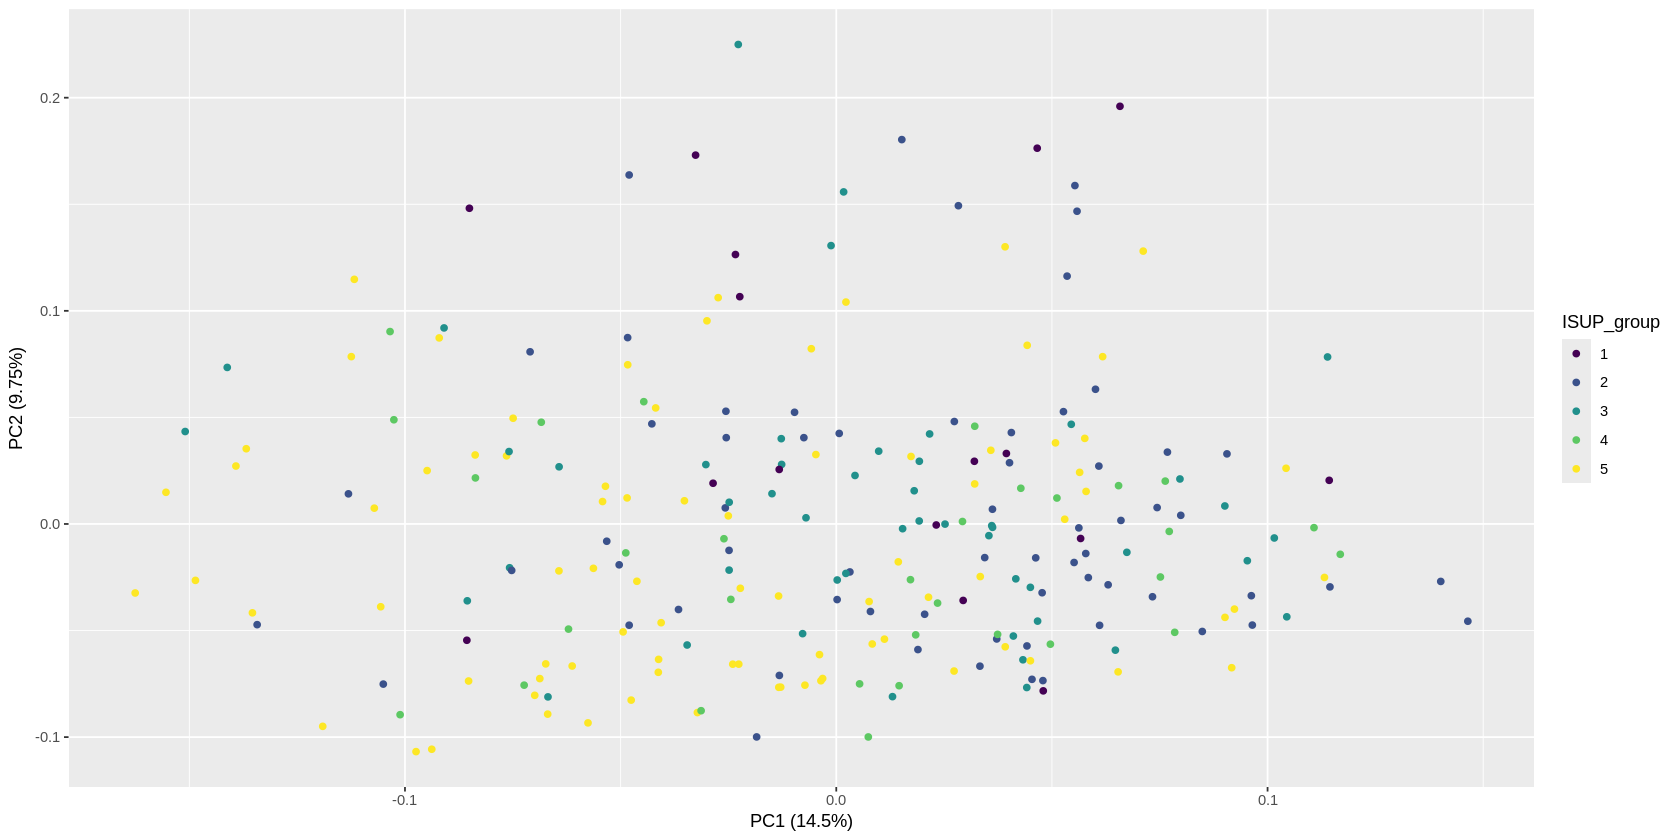

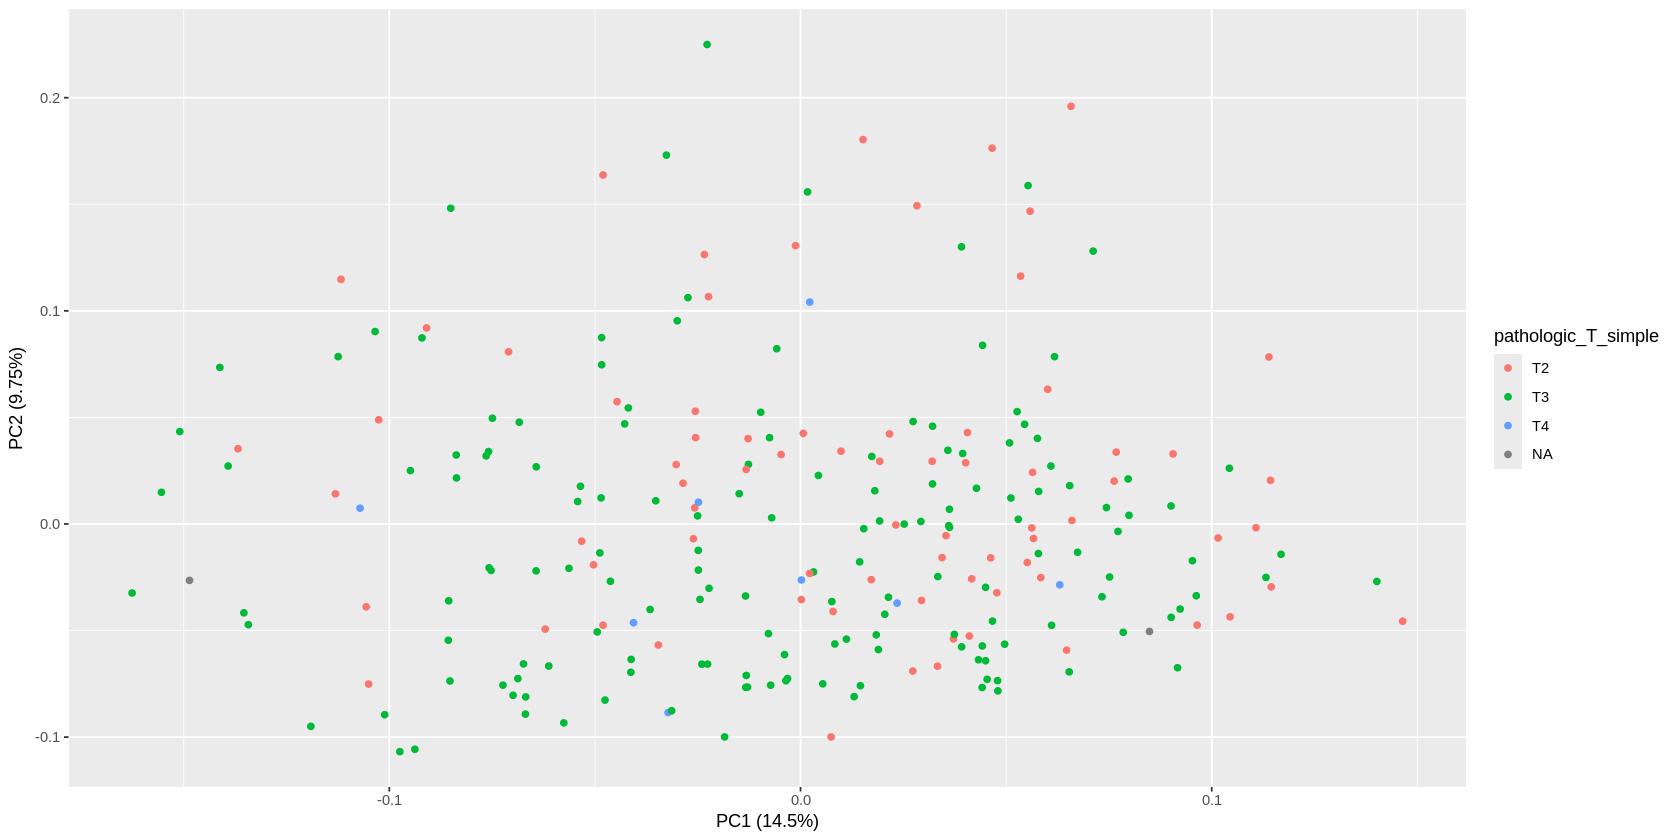

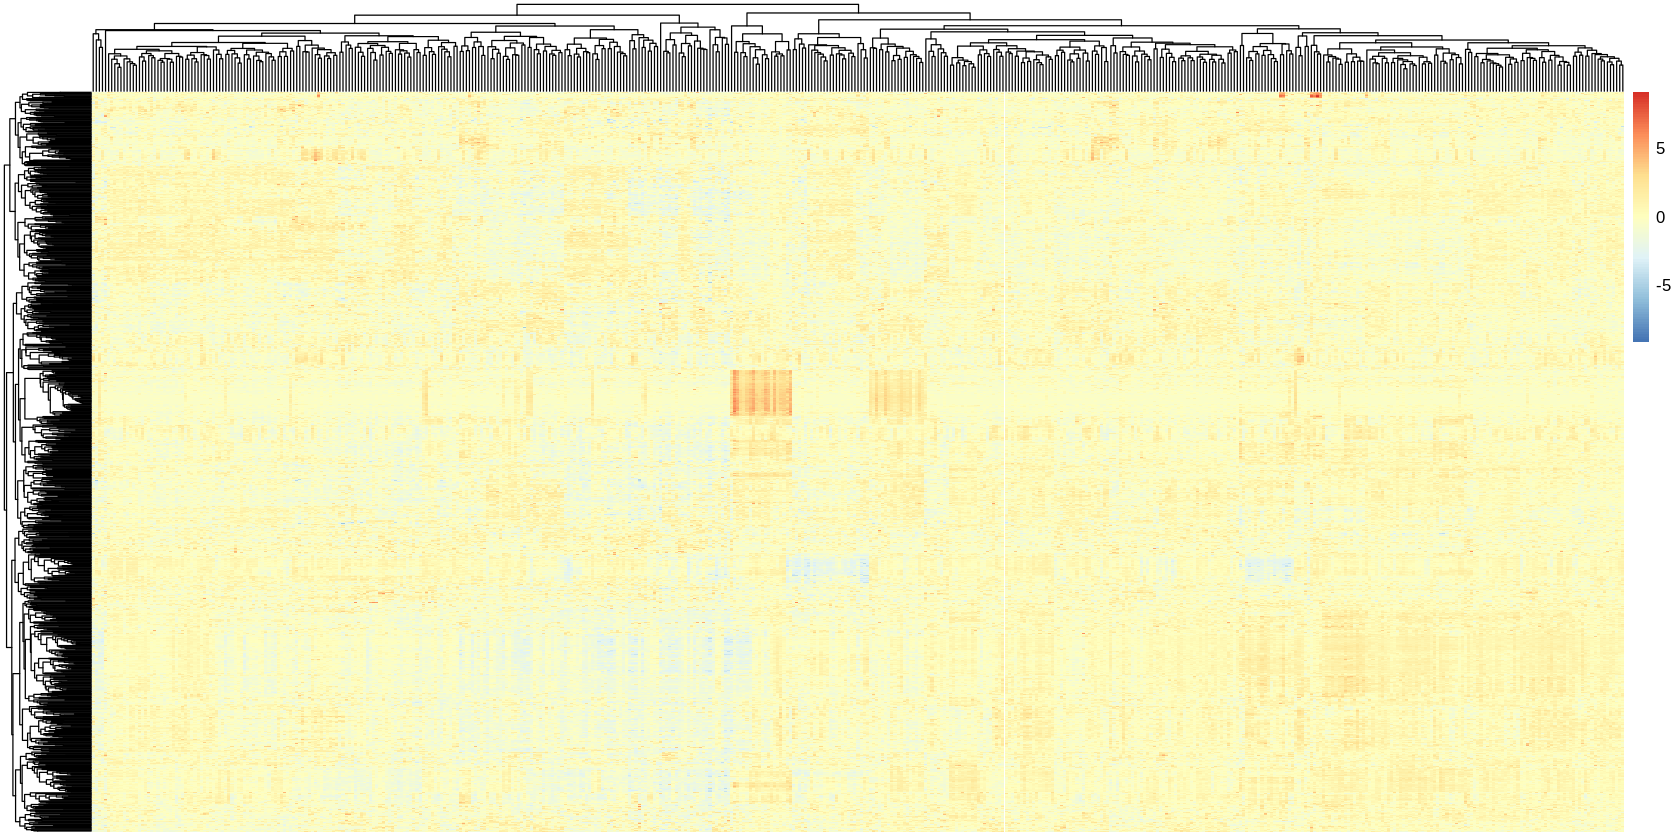

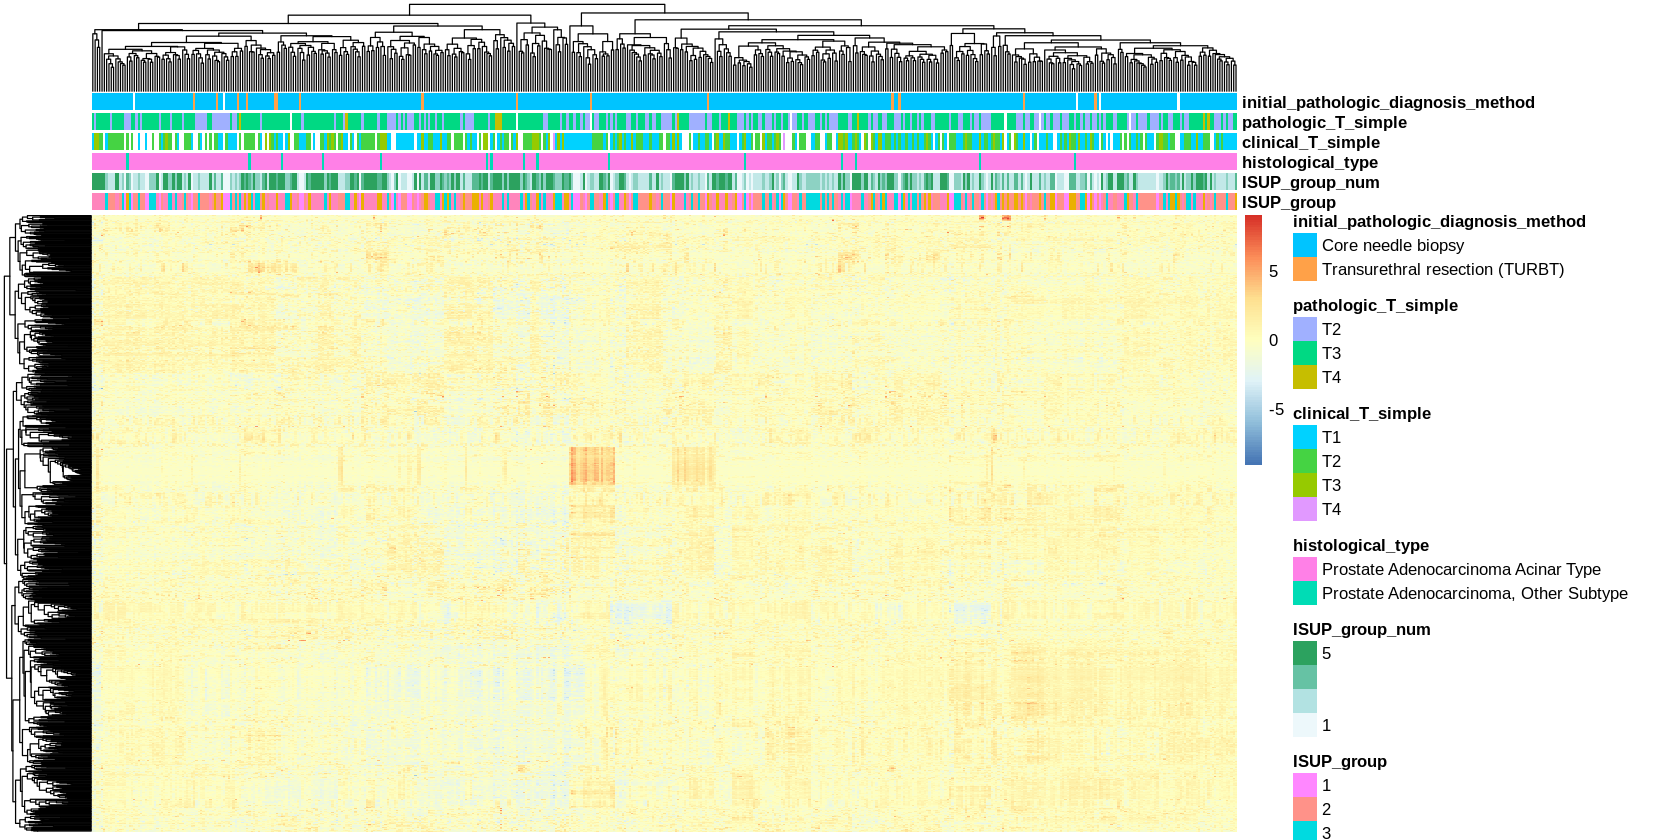

In [21]:

features=colnames(exp)
# PCA Analysis
pca <- prcomp(classification_table[features], scale. = TRUE)
autoplot(pca, data = classification_table, colour = "ISUP_group")
autoplot(pca, data = classification_table, colour = "pathologic_T_simple")


# Generate heatmap without annotations
pheatmap(t(exp), show_rownames = FALSE, show_colnames = FALSE, scale = "row")

# Prepare annotations from phenotypic data
annotations <- pheno %>%
  select(ISUP_group, ISUP_group_num, histological_type, clinical_T_simple, pathologic_T_simple, initial_pathologic_diagnosis_method)

# Generate heatmap with annotations
pheatmap(t(exp), scale = "row", annotation = annotations, show_rownames = FALSE, show_colnames = FALSE)


# K-Means Clustering

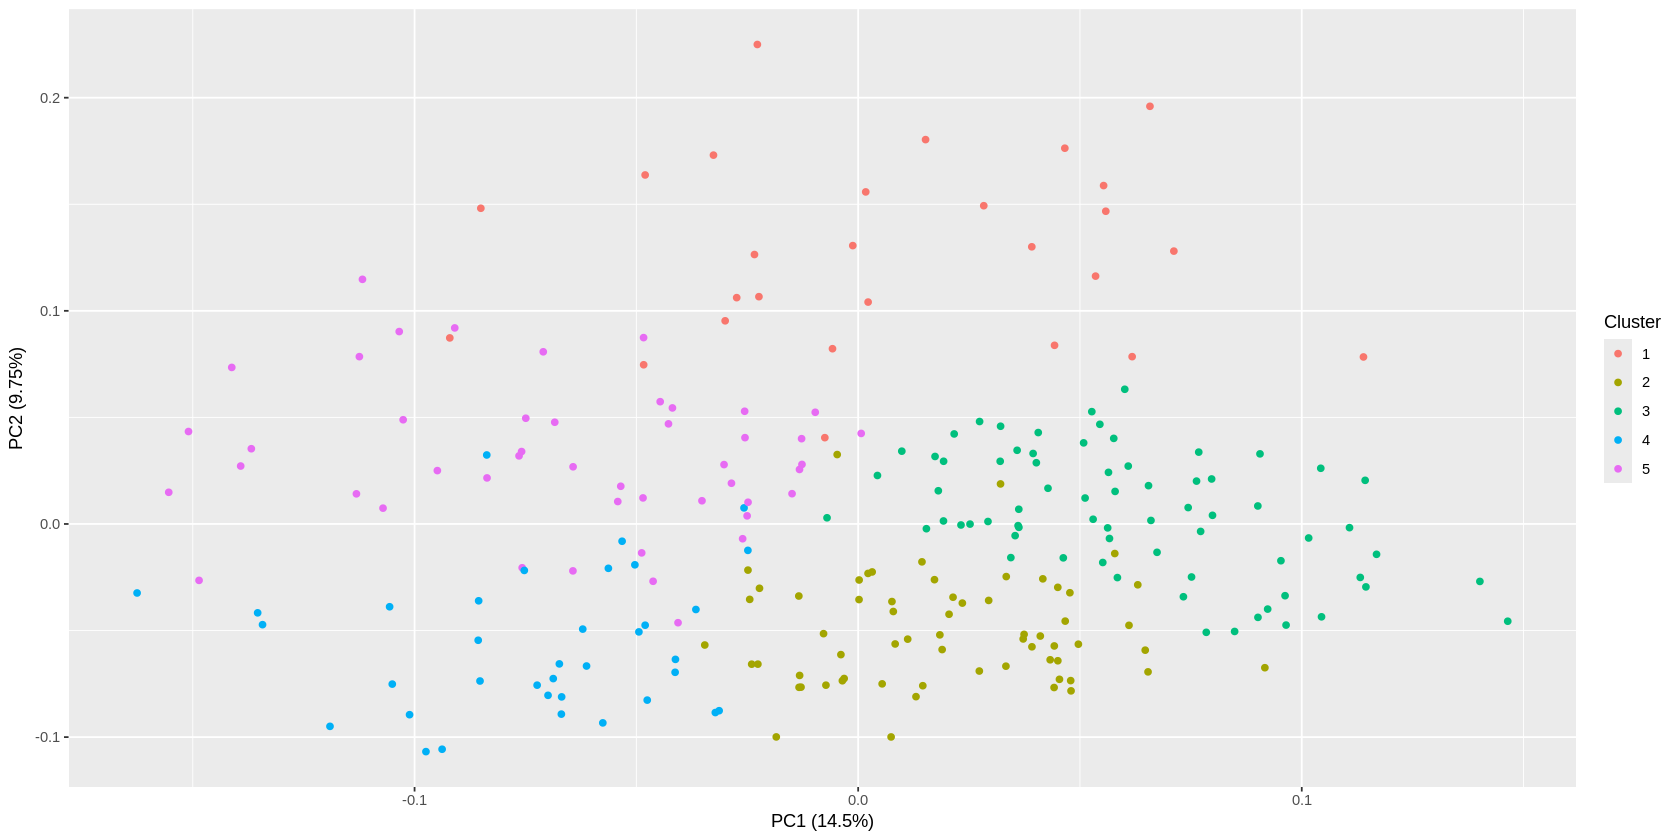

In [22]:

set.seed(123)

# Perform K-means clustering with 5 centers
kmeans_result <- kmeans(classification_table[features], centers = 5, nstart = 25)
cluster_kmeans <- data.frame(Cluster = factor(kmeans_result$cluster))

# Visualize PCA with K-means clusters
autoplot(pca, data = cluster_kmeans, colour = "Cluster")


# tsnea

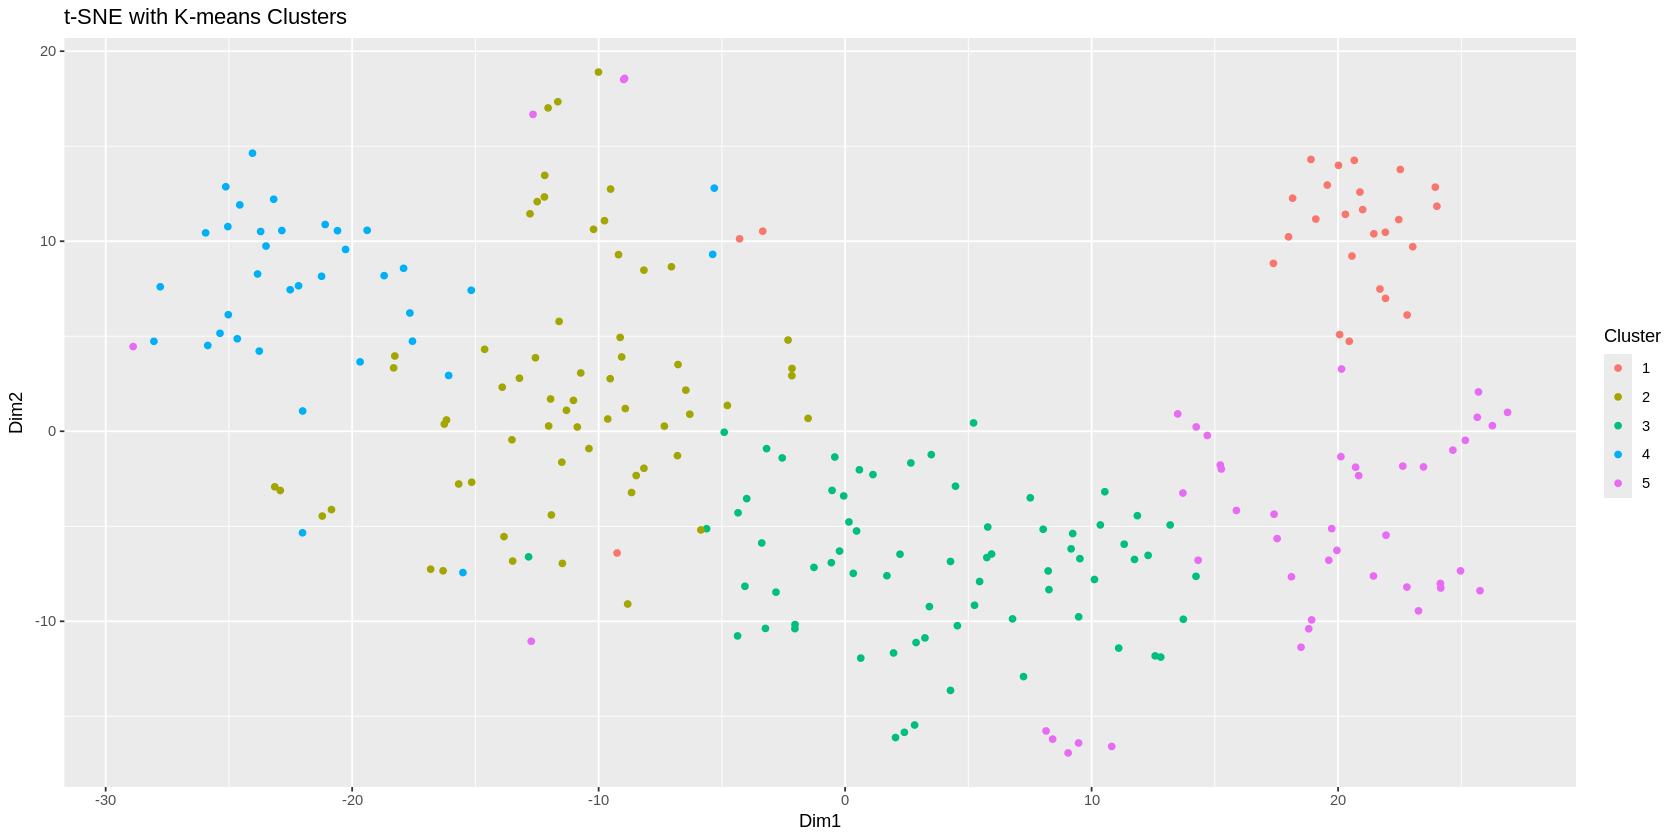

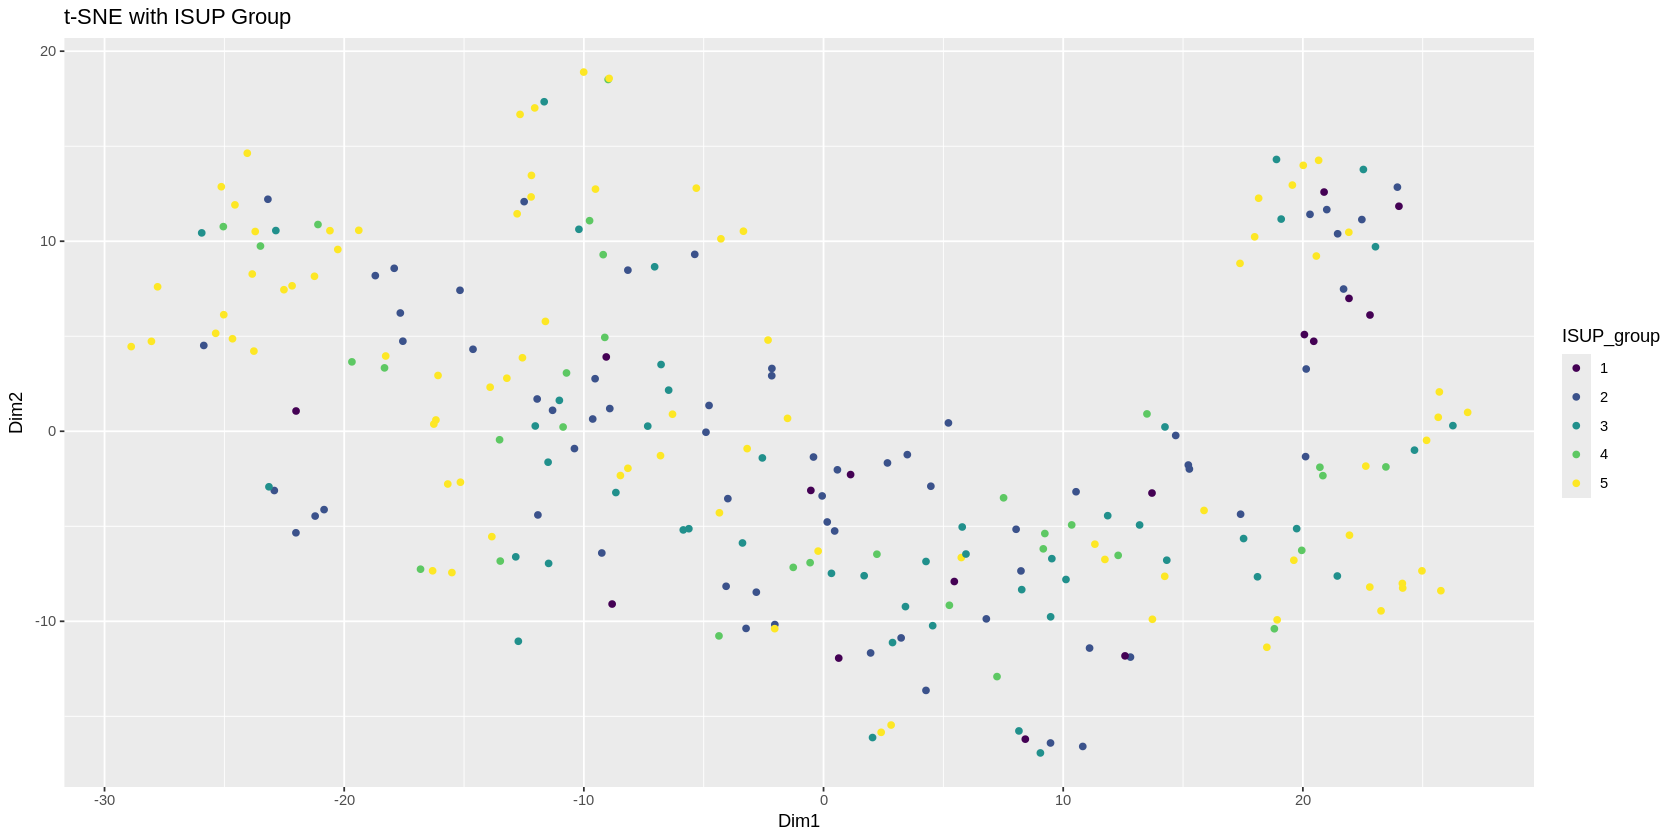

In [23]:
set.seed(123)

# Perform t-SNE on the expression data
tsne_result <- Rtsne(classification_table[features], perplexity = 10)

# Create a data frame for t-SNE results
tsne_data <- data.frame(Dim1 = tsne_result$Y[,1], Dim2 = tsne_result$Y[,2], Cluster = cluster_kmeans$Cluster, ISUP_group = classification_table$ISUP_group)

# Visualize t-SNE colored by K-means clusters
ggplot(tsne_data, aes(x = Dim1, y = Dim2, color = Cluster)) +
  geom_point() +
  labs(title = "t-SNE with K-means Clusters")

# Visualize t-SNE colored by ISUP group
ggplot(tsne_data, aes(x = Dim1, y = Dim2, color = ISUP_group)) +
  geom_point() +
  labs(title = "t-SNE with ISUP Group")


# Association with Clinical Features

Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


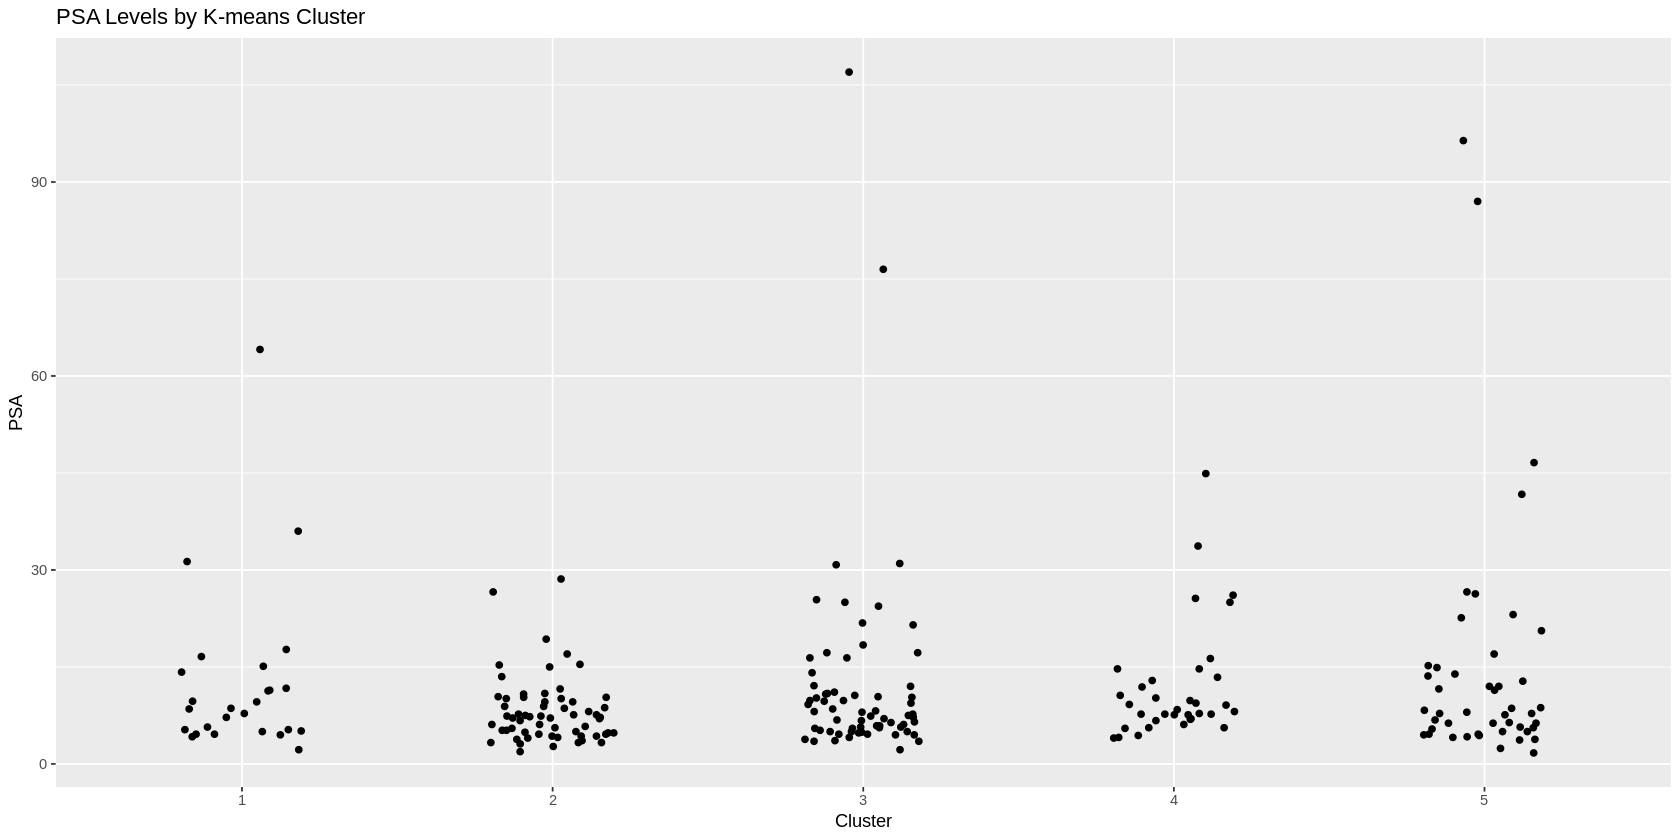

In [24]:
# Combine phenotypic data with K-means clusters
pheno_cluster <- cbind(classification_table, Cluster = cluster_kmeans$Cluster)

# Visualize PSA levels across clusters
ggplot(pheno_cluster, aes(x = Cluster, y = PSA)) +
  geom_jitter(width = 0.2, height = 0) +
  labs(title = "PSA Levels by K-means Cluster", x = "Cluster", y = "PSA")



---

## 3. Initial Model Training & Feature Selection


### 3.1. Train/Test Partition

In [25]:
dim(classification_table)

[1]  243 1019

In [26]:



features <- colnames(exp)
X <- classification_table[, features]
y <- classification_table[, "Class"]

set.seed(123)
train_index <- createDataPartition(y, p = 0.7, list = FALSE)
training <- classification_table[train_index, c(features, "Class") ]
testing  <- classification_table[-train_index,c(features, "Class") ]


# Check class proportions
prop.table(table(training$Class))
prop.table(table(testing$Class))


        0         1 
0.7017544 0.2982456 


        0         1 
0.7083333 0.2916667 

### Train classification algorithms

We define a cross-validation setup and train three models: k-Nearest Neighbors (kNN), Support Vector Machine (SVM), and Random Forest (RF).

In [31]:
# Cross-validation setup
control <- trainControl(method = "cv", number = 3)
metric <- "Accuracy"

# Train models
fit.knn <- train(Class ~ ., data = training, method = "knn", metric = metric, trControl = control)
fit.svm <- train(Class ~ ., data = training, method = "svmRadial", metric = metric, trControl = control)
fit.rf  <- train(Class ~ ., data = training, method = "rf", metric = metric, trControl = control)

### Compare model performance

We compare the performance of the trained models using resampling results.


Call:
summary.resamples(object = results)

Models: KNN, SVM, RF 
Number of resamples: 3 

Accuracy 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
KNN 0.6842105 0.6929825 0.7017544 0.7076023 0.7192982 0.7368421    0
SVM 0.7017544 0.7017544 0.7017544 0.7017544 0.7017544 0.7017544    0
RF  0.7017544 0.7105263 0.7192982 0.7134503 0.7192982 0.7192982    0

Kappa 
         Min.    1st Qu.     Median       Mean    3rd Qu.       Max. NA's
KNN 0.0453202 0.04941287 0.05350554 0.08548707 0.10557050 0.15763547    0
SVM 0.0000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000    0
RF  0.0000000 0.04032258 0.08064516 0.05376344 0.08064516 0.08064516    0


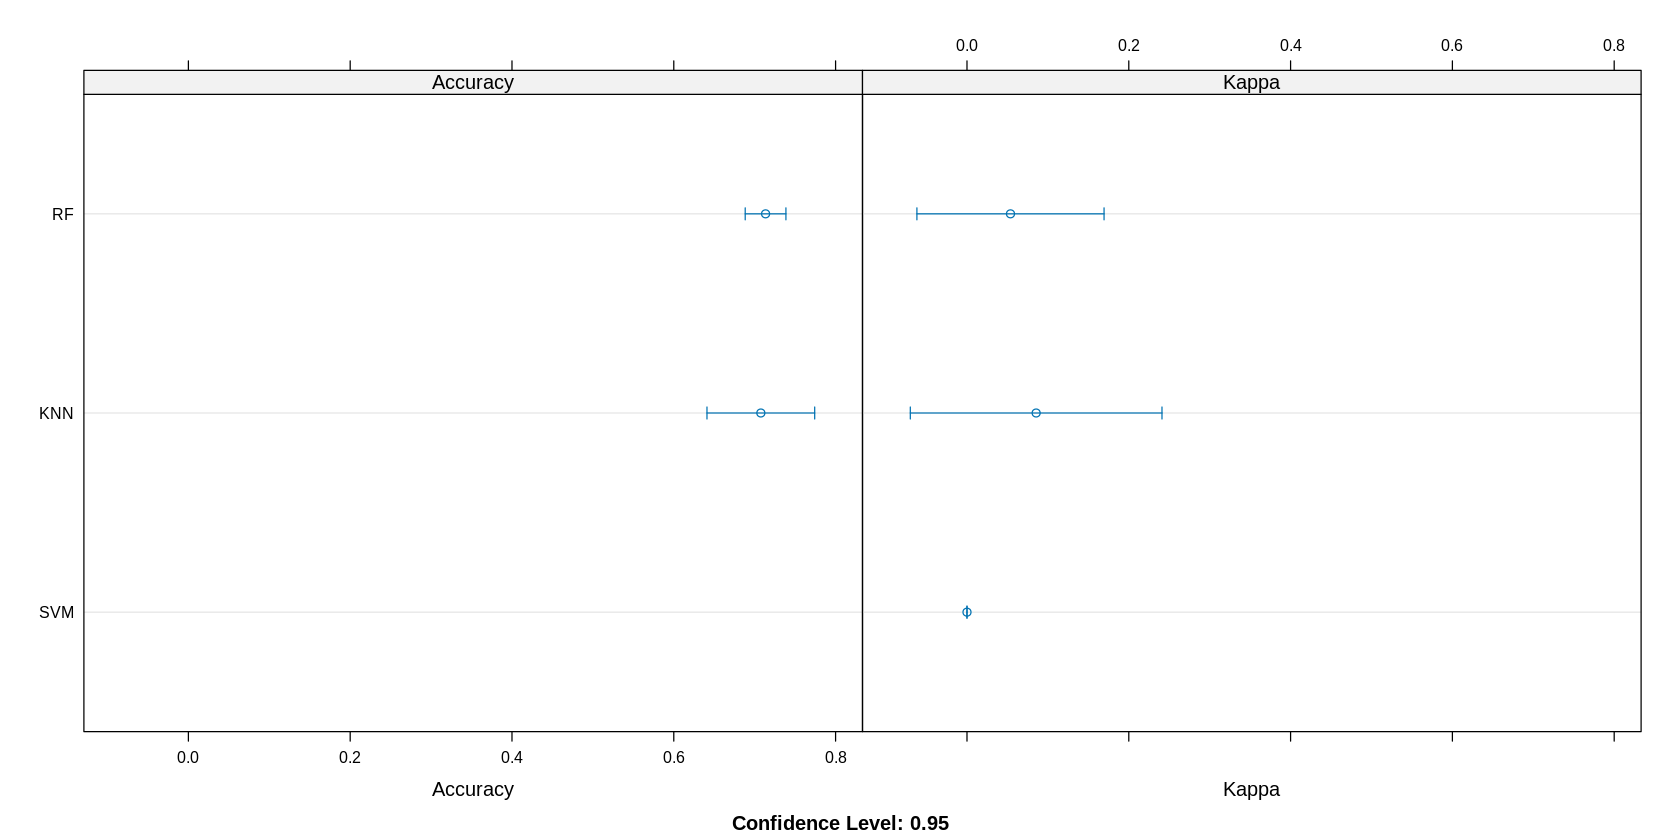

In [32]:
# Compare models
results <- resamples(list(KNN = fit.knn, SVM = fit.svm, RF = fit.rf))
summary(results)
dotplot(results)

### Feature importance with Random Forest

We explore the importance of variables using the Random Forest model and rank the features.

,Overall
,<dbl>
GSTT1,13.495240
TGM4,12.429588
COL2A1,39.991901
ORM1,20.920756
MYH7,20.846957
CRISP3,25.241242
GSTM1,38.227716
NPY,18.618663
SEMG1,39.680847


rf variable importance

  only 20 most important variables shown (out of 1000)

          Overall
AMH        100.00
SPAG6       92.62
CHRNA2      87.59
DLGAP1      82.78
TBX4        81.21
PCGEM1      78.21
CLVS2       76.59
IGSF1       75.41
PAGE4       73.16
SAA2        71.94
P2RX2       71.67
CCDC78      71.58
APOF        70.96
SFTPA2      70.49
ARHGDIG     69.52
SCARA5      69.31
LOC572558   69.11
OR51E1      68.17
HOXC4       67.73
PTPRZ1      66.02


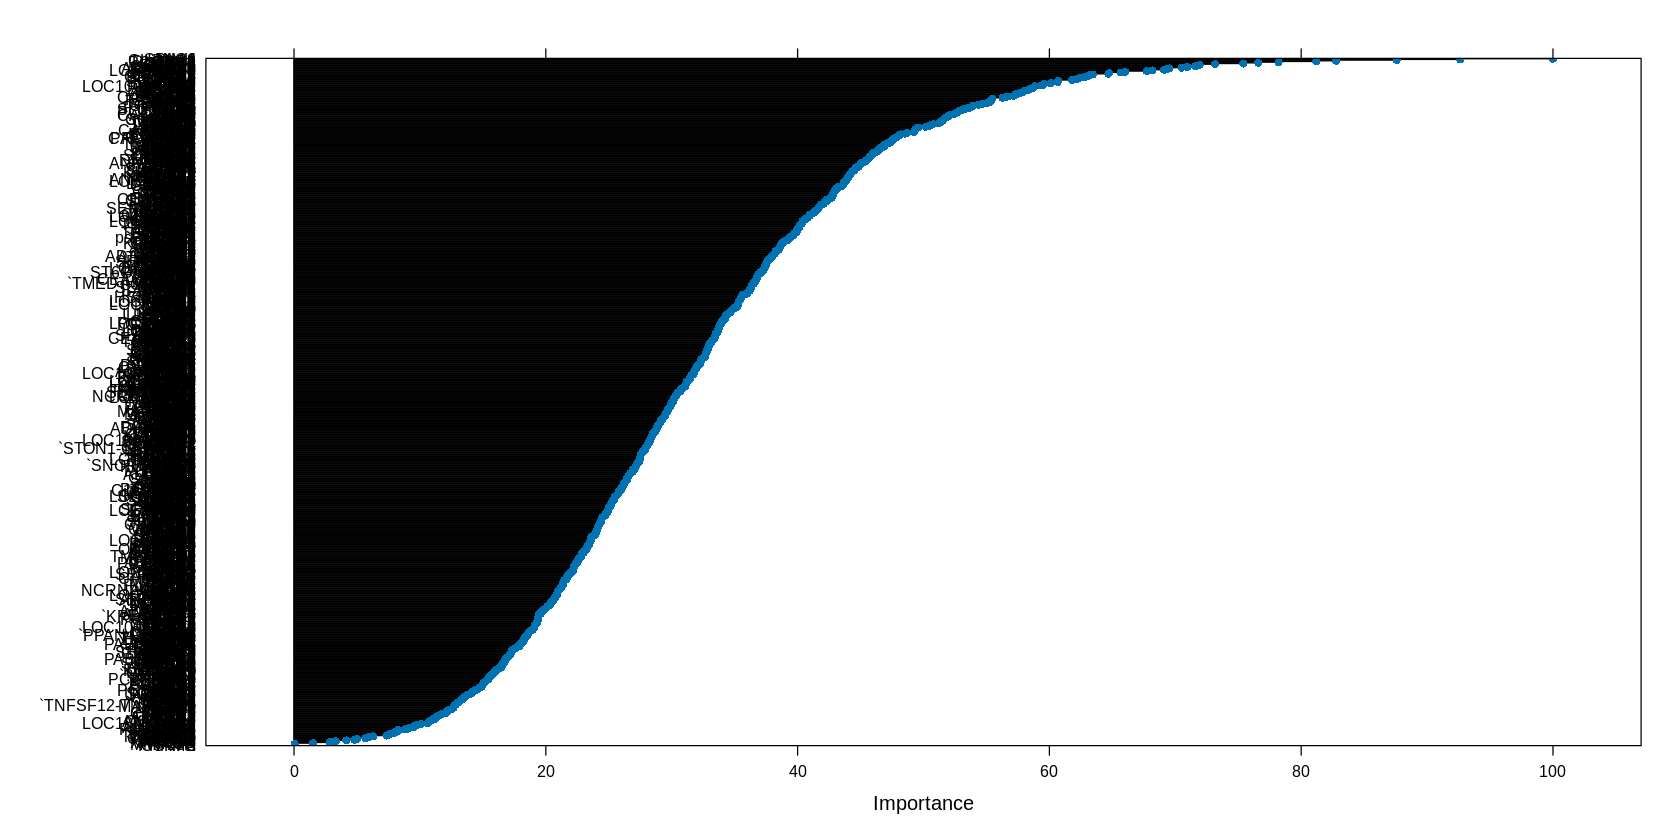

In [33]:
# Feature importance
importance <- varImp(fit.rf)
head(importance)
print(importance)
plot(importance)

# Rank features by importance
IndexRank <- data.frame(sort(importance$importance$Overall, index.return = TRUE, decreasing = TRUE)[2])
Ranking <- t(IndexRank)

We use this ranking to reorder the training, testing, and full datasets.

In [42]:
# Reorder datasets by importance
trainingrank <- training[, c(Ranking, which(colnames(training)=="Class"))]
testingrank  <- testing[, c(Ranking, which(colnames(testing)=="Class"))]
datosrank    <- classification_table[, c(Ranking, which(colnames(classification_table)=="Class"))]

# Select top k features
k <- 30
trainingrank.top <- trainingrank[, c(1:k, which(colnames(trainingrank)=="Class"))]
testingrank.top  <- testingrank[, c(1:k, which(colnames(testingrank)=="Class"))]
datosrank.top    <- datosrank[, c(1:k, which(colnames(datosrank)=="Class"))]

In [40]:
head(datosrank.top)
colnames(datosrank.top)

,TRIM54,GRM7,ATF3,PPP1R1A,ATP8A2,ANKRD34B,CCBE1,CDC20B,CALML3,ZIC2,⋯,TSPAN19,PCDHA12,OTX1,UTS2D,PRSS16,CCL19,DPYSL5,SSTR1,ACTC1,CTAG1B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.7236,1.5820,11.4449,4.6776,1.5820,2.3184,5.0107,0.0000,1.2198,1.5820,⋯,5.2051,1.4584,7.3965,0.0000,5.0107,7.0068,0.7352,6.5553,10.0648,0.0000
2,0.4516,9.6816,9.0629,3.1840,5.9026,11.2744,1.6807,2.2254,3.6319,5.6302,⋯,1.8373,4.7411,6.6996,3.6741,6.9857,5.8484,2.1073,13.3692,4.5947,2.2254
3,1.5923,1.8152,10.0167,4.0979,5.0331,2.0083,3.8176,0.0000,9.3598,5.2396,⋯,3.7651,3.8052,6.5959,4.3324,1.0055,3.7651,2.3308,6.2106,8.0663,0.5886
4,0.4946,3.6847,9.2905,4.3376,9.5526,3.1982,4.8887,0.0000,4.5287,8.1074,⋯,2.8347,3.5913,5.1766,1.1549,6.4340,6.8207,3.2611,8.4402,5.4573,0.0000
5,0.0000,0.0000,9.6761,3.9075,2.2690,0.0000,3.7343,0.0000,0.8867,3.5892,⋯,3.3094,4.7087,8.9100,2.5031,8.0886,4.8158,1.8265,5.2125,3.9478,0.5104
6,1.0348,1.0348,10.2473,4.4918,1.0348,1.8567,4.7666,0.0000,1.0348,4.9244,⋯,4.2349,3.4786,7.0339,1.8567,3.0603,10.5530,2.0518,6.5025,7.0961,0.0000


[1] "TRIM54"    "GRM7"      "ATF3"      "PPP1R1A"   "ATP8A2"    "ANKRD34B" 
 [7] "CCBE1"     "CDC20B"    "CALML3"    "ZIC2"      "RDH16"     "CCL20"    
[13] "PITX2"     "NRG4"      "MYBPH"     "CEACAM6"   "SYT13"     "LOC642587"
[19] "GABRA1"    "KIAA0408"  "TSPAN19"   "PCDHA12"   "OTX1"      "UTS2D"    
[25] "PRSS16"    "CCL19"     "DPYSL5"    "SSTR1"     "ACTC1"     "CTAG1B"

### PCA on top-k features

We repeat the PCA using only the top k features.

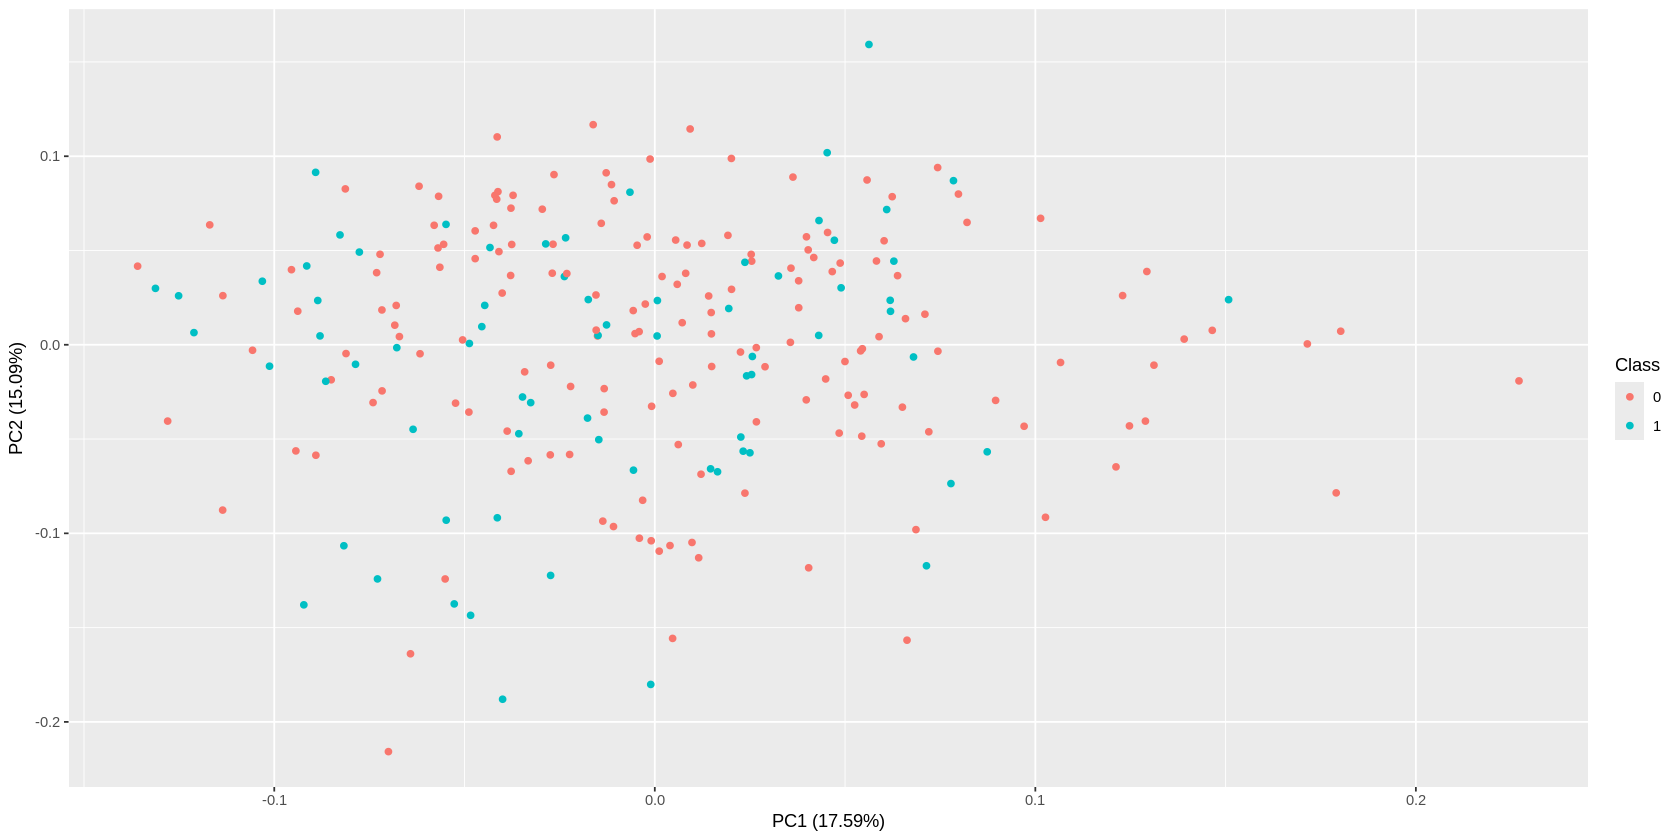

In [43]:
# PCA on top-k features
pca <- prcomp(datosrank.top[, 1:k])
autoplot(pca, data = datosrank.top, colour = "Class")


### Retrain Random Forest with top-k features

We ensure matching column names and retrain RF using only top-k features.

In [44]:
# Check column name consistency
colnames(trainingrank.top) == colnames(testingrank.top)

# Retrain model with top-k features
fit.rf.top <- train(Class ~ ., data = trainingrank.top, method = "rf", metric = metric, trControl = control)
fit.rf.top

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE

Random Forest 

171 samples
 30 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 114, 114, 114 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.7426901  0.2849077
  16    0.7426901  0.3146866
  30    0.7192982  0.2847456

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

We explore the new importance ranking.

,Overall
,<dbl>
AMH,100.00000
SPAG6,37.70494
CHRNA2,87.68821
DLGAP1,69.34071
TBX4,46.41387
PCGEM1,46.30261
CLVS2,17.95597
IGSF1,28.91894
PAGE4,27.79286


rf variable importance

  only 20 most important variables shown (out of 30)

          Overall
AMH        100.00
CHRNA2      87.69
SFTPA2      81.03
CCDC78      78.52
APOF        75.40
GALNT13     75.25
DLGAP1      69.34
CCDC67      53.78
DPEP1       51.43
LOC572558   49.55
TBX4        46.41
PCGEM1      46.30
ARHGDIG     44.96
P2RX2       39.78
SCARA5      39.14
SLC45A2     38.84
SPAG6       37.70
CPS1        35.81
SLC27A6     34.89
IGSF1       28.92


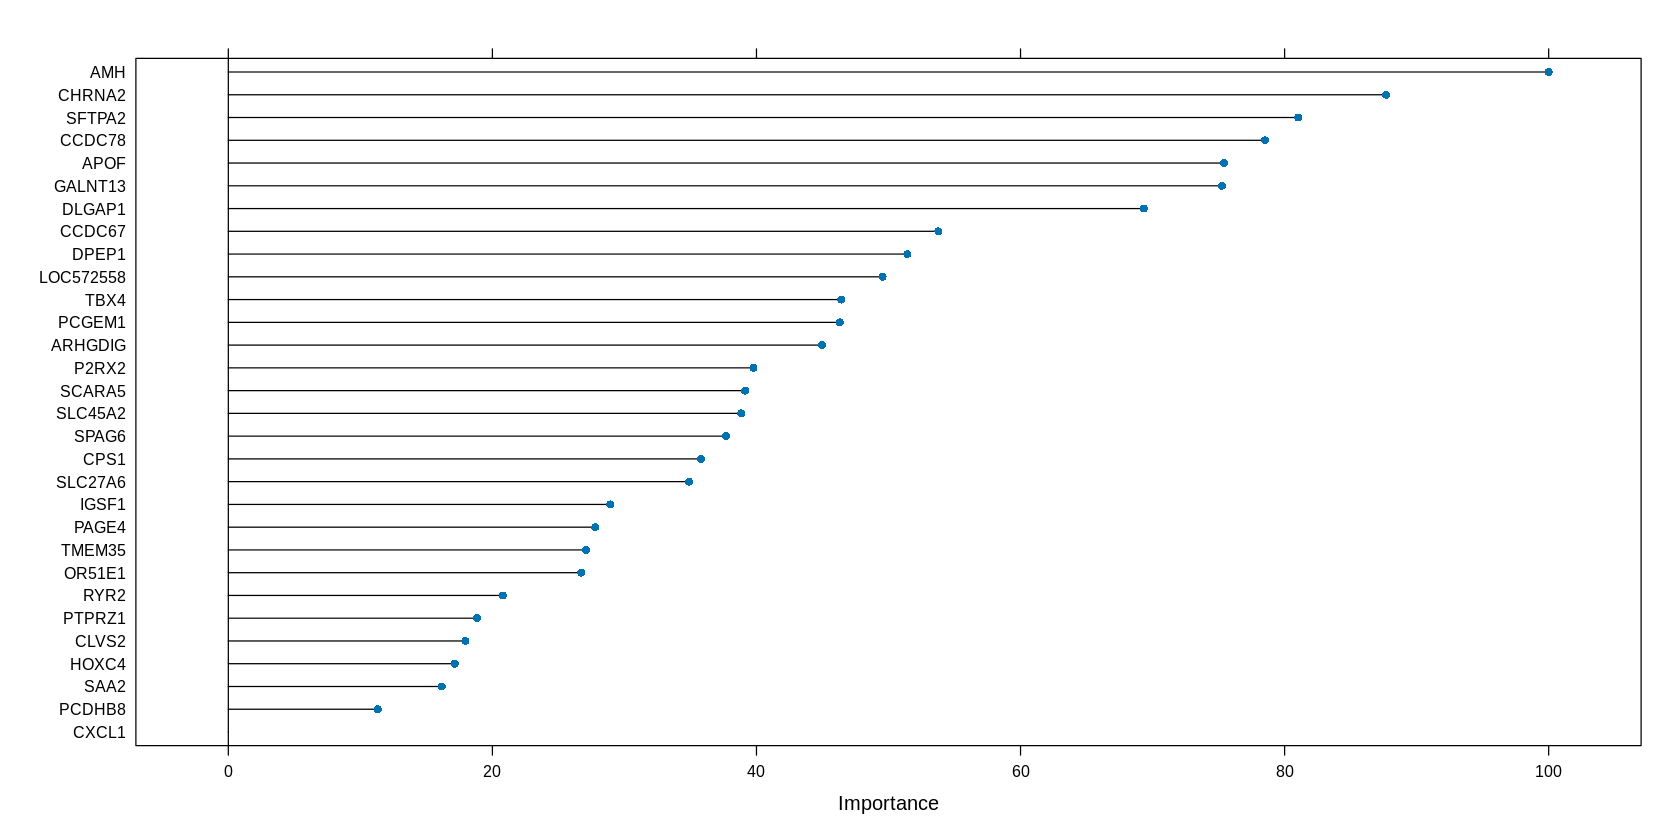

In [45]:
# Feature importance from top-k RF model
importance <- varImp(fit.rf.top)
head(importance)
print(importance)
plot(importance)

### Compare full vs top-k RF models


Call:
summary.resamples(object = results)

Models: RF.all, RF.topk 
Number of resamples: 3 

Accuracy 
             Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
RF.all  0.7017544 0.7105263 0.7192982 0.7134503 0.7192982 0.7192982    0
RF.topk 0.7017544 0.7105263 0.7192982 0.7426901 0.7631579 0.8070175    0

Kappa 
              Min.    1st Qu.     Median       Mean    3rd Qu.       Max. NA's
RF.all  0.00000000 0.04032258 0.08064516 0.05376344 0.08064516 0.08064516    0
RF.topk 0.08671065 0.17019657 0.25368249 0.28490770 0.38400623 0.51432998    0


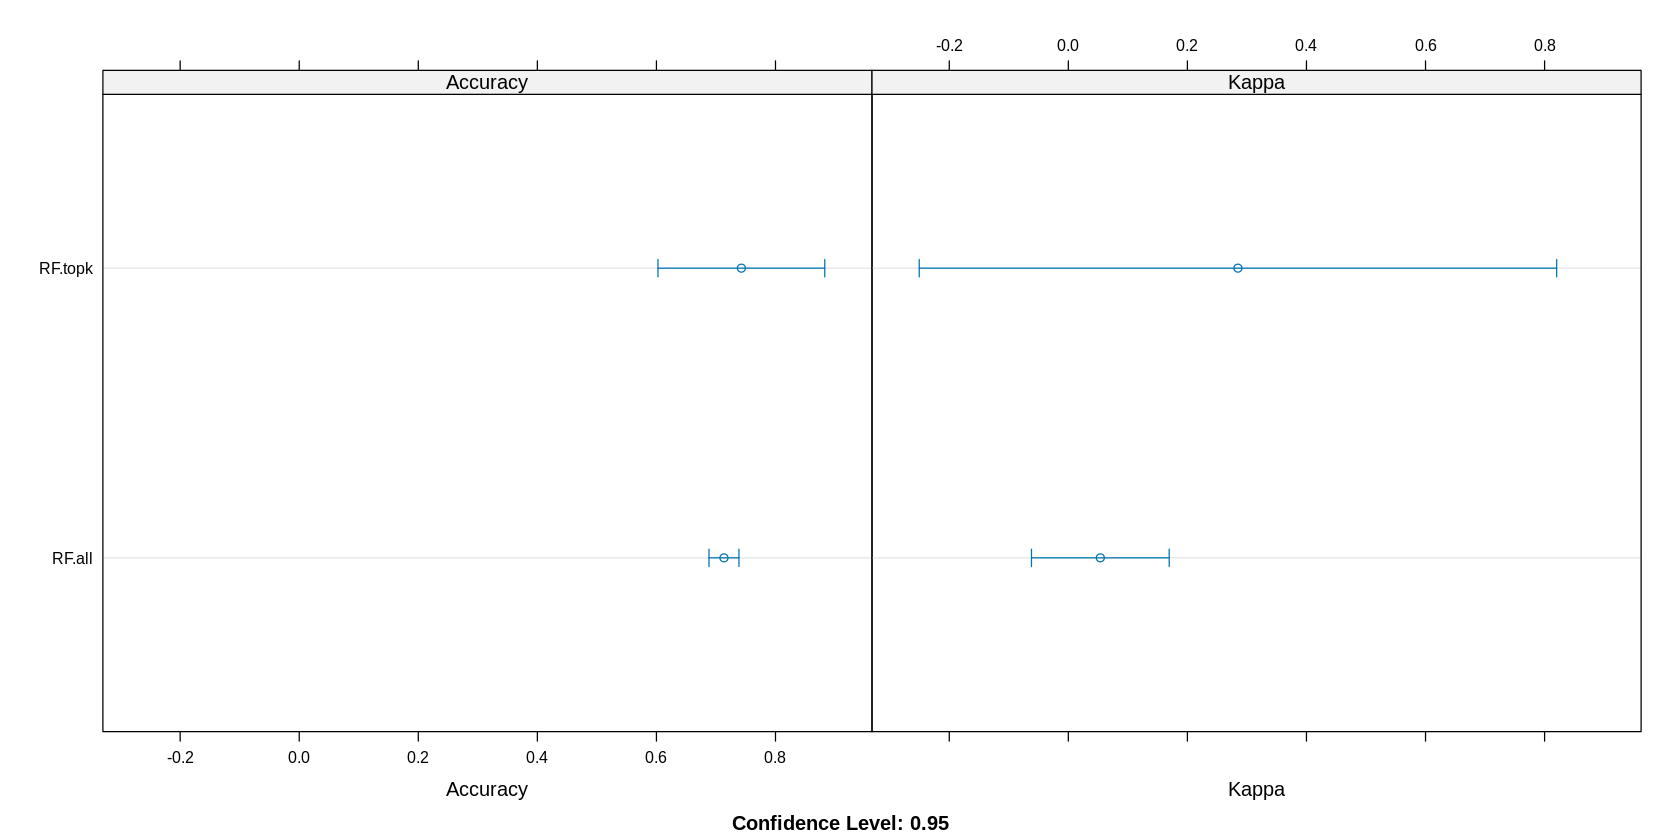

In [46]:
# Compare full model vs top-k model
results <- resamples(list(RF.all = fit.rf, RF.topk = fit.rf.top))
summary(results)
dotplot(results)

### Test set predictions

We evaluate model predictions on the test set using both full and top-k models.

In [47]:
# Predict with full model
predictions <- predict(fit.rf, testing)
Statistics <- confusionMatrix(predictions, testing$Class)
Statistics$overall

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  6.944444e-01  -2.723735e-02   5.746833e-01   7.976201e-01   7.083333e-01 
AccuracyPValue  McnemarPValue 
  6.568461e-01   5.103985e-05

In [48]:
# Predict with top-k model
predictions2 <- predict(fit.rf.top, testingrank.top)
Statistics2 <- confusionMatrix(predictions2, testingrank.top$Class)
Statistics2$overall

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
    0.65277778     0.03846154     0.53136717     0.76118723     0.70833333 
AccuracyPValue  McnemarPValue 
    0.87729250     0.10959858

### ROC curve and AUC for top-k model

We calculate the ROC curve and AUC for the top-k RF model.

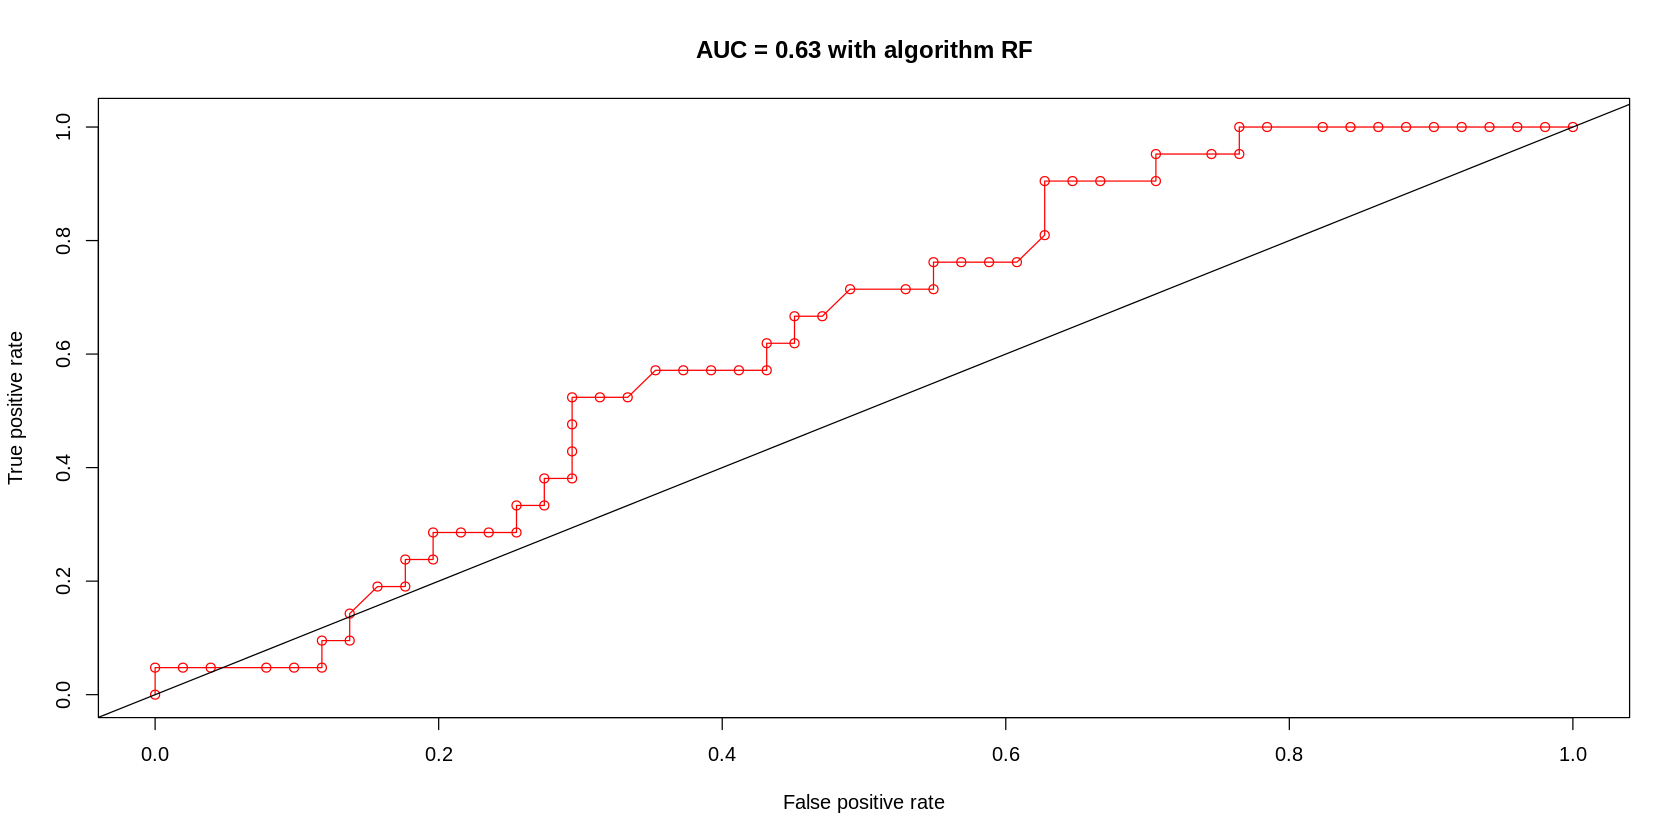

In [49]:
# ROC and AUC calculation
predictionsKSroc <- predict(fit.rf.top, testingrank.top, type = "prob")[, 2]
predict.rocr  <- prediction(predictionsKSroc, testingrank.top$Class)
perf.rocr     <- performance(predict.rocr, "tpr", "fpr")
auc <- as.numeric(performance(predict.rocr ,"auc")@y.values)

# Plot ROC curve
par(mfrow = c(1,1))
plot(perf.rocr, type = 'o', col = "red", main = paste('AUC =', round(auc, 2), "with algorithm RF"), ylim = c(0, 1.01), xlim = c(0, 1))
abline(a = 0, b = 1)

### Boxplots of top features

Finally, we visualize the expression of the top 6 features using boxplots by class.

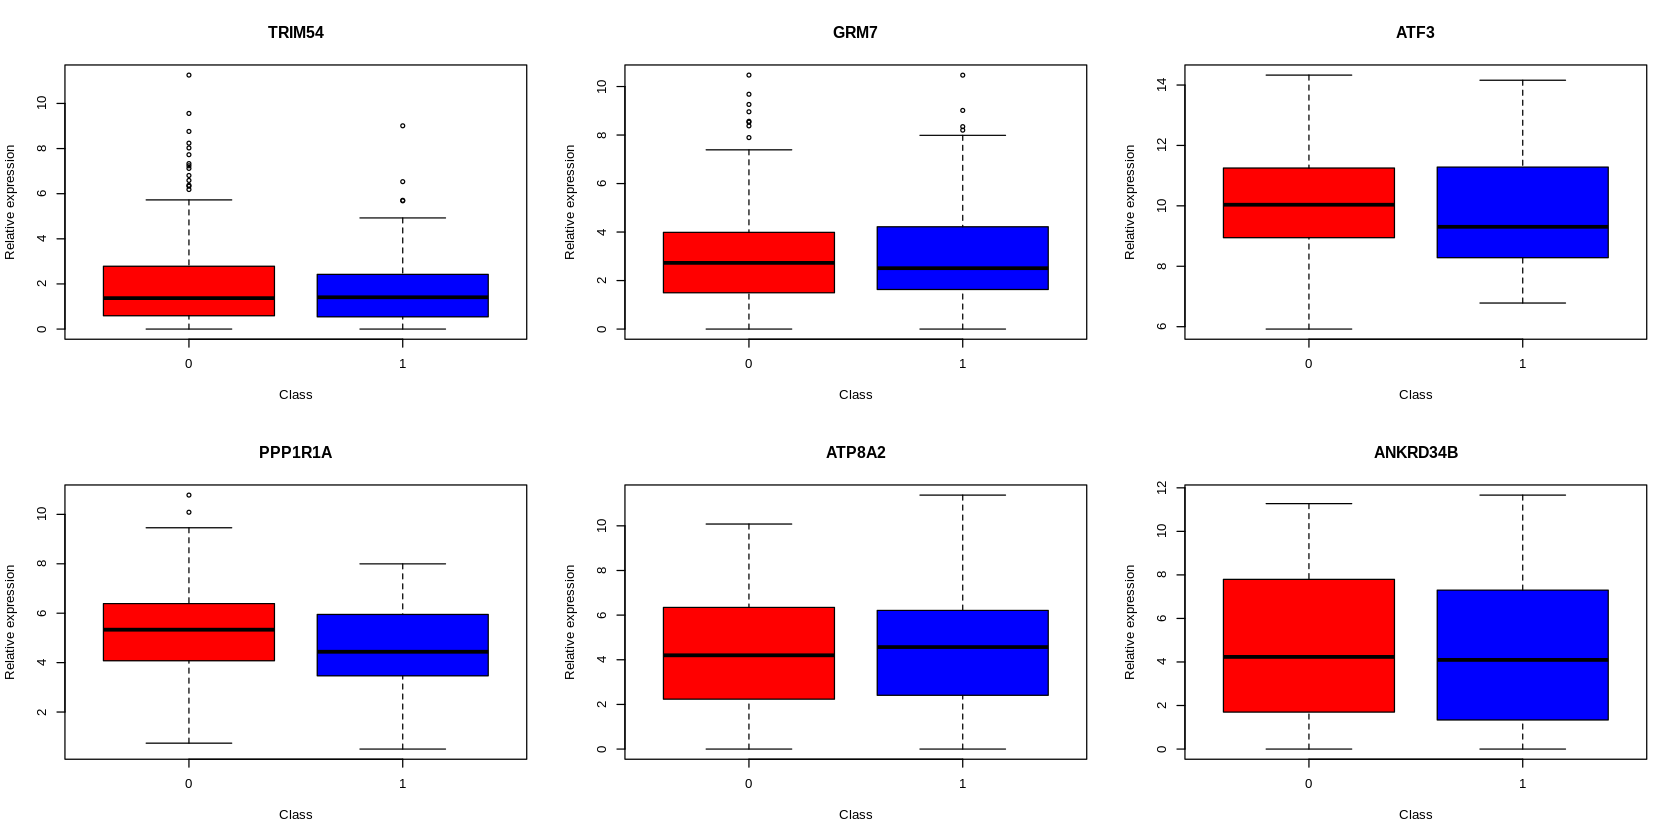

In [50]:
# Boxplot of top 6 features by class
par(mfrow = c(2,3))
for (i in 1:6) {
  boxplot(datosrank[, i] ~ datosrank$Class,
          main = names(datosrank)[i],
          xlab = "Class",
          ylab = "Relative expression",
          col = c("red", "blue"))
}
par(mfrow = c(1,1))

### 3.2. Initial Model Training and Feature Importance

We train a Random Forest model on all genes to identify the most important features.

In [51]:
# Define cross-validation control
control <- trainControl(method = "cv", number = 5)
metric <- "Accuracy"


# Train models
fit.knn <- train(Class ~ ., data = training, method = "knn", metric = metric, trControl = control)
fit.svm <- train(Class ~ ., data = training, method = "svmRadial", metric = metric, trControl = control)
fit.rf  <- train(Class ~ ., data = training, method = "rf", metric = metric, trControl = control)


# Train a Random Forest model on the training data using all molecular features
fit.rf.all <- train(
  x = training[, features],
  y = training$Class,
  method = "rf",
  metric = metric,
  trControl = control
)

# Calculate and plot variable importance
importance <- varImp(fit.rf.all)
plot(importance, top = 20)

# Extract the names of the top 30 features
importance_df <- as.data.frame(importance$importance)
ranked_features <- rownames(importance_df)[order(importance_df$Overall, decreasing = TRUE)]
top_k_features <- ranked_features[1:30]

---

## 4. Final Model Evaluation on Test Set

We evaluate a refined model using only the top 30 genes on the held-out test set.

In [ ]:
# Train a new RF model with only the top 30 features
fit.rf.top <- train(
  x = training[, top_k_features],
  y = training$Class,
  method = "rf",
  metric = metric,
  trControl = control
)

# Evaluate on the test set
predictions_top_k <- predict(fit.rf.top, testing[, top_k_features])
cm_top_k <- confusionMatrix(predictions_top_k, testing$Class, positive = "1")
print(cm_top_k)

# ROC Curve
pred_probs <- predict(fit.rf.top, testing[, top_k_features], type = "prob")[, "1"]
pred_rocr <- prediction(pred_probs, testing$Class)
perf_rocr <- performance(pred_rocr, "tpr", "fpr")
auc <- performance(pred_rocr, "auc")@y.values[[1]]
plot(perf_rocr, colorize = TRUE, main = paste('ROC for Top-30 Gene RF Model\nAUC =', round(auc, 3)))
# abline(a = 0, b = 1, lty = 2)

---

## 5. Comprehensive Algorithm Benchmarking

In this final section, we conduct a rigorous benchmark to compare multiple classification algorithms. We will test each algorithm under two conditions:
1.  **Molecular Model:** Using only the top 30 gene expression features.
2.  **Combined Model:** Using the top 30 genes *plus* key clinical variables.

This will allow us to determine not only the best-performing algorithm but also to quantify the added predictive value of clinical data.

### 5.1. Data Preparation for Benchmarking

First, we define the clinical variables to include and create the two datasets for our comparison.

In [ ]:
# Define the clinical features we want to add to the model
# These should be variables with low missingness and potential predictive value.
clinical_features <- c("age", "PSA", "pathologic_T_simple")


# Create the "molecular-only" dataset using the top 30 genes
molecular_model_data <- classification_table %>%
  select(all_of(top_k_features), Class)

molecular_model_data$Class=factor(molecular_model_data$Class, labels = c("No_Recurrence", "Recurrence"))

# Create the "combined" dataset with both molecular and clinical features
# Note: Caret handles dummy-encoding of factor variables (like pathologic_T_simple) automatically.
combined_model_data <- classification_table %>%
  select(all_of(top_k_features), all_of(clinical_features), Class) %>% na.omit()
combined_model_data$Class=factor(combined_model_data$Class, labels = c("No_Recurrence", "Recurrence"))

# Handle missing values, e.g., by median imputation (a simple but effective method)
# Caret's preProcess can do this within the train function for a more robust workflow.

### 5.2. Model Training with Repeated Cross-Validation

We will use **10-fold cross-validation, repeated 3 times** (`repeatedcv`). This provides a more stable estimate of model performance than a single train/test split.

In [ ]:
# Set up the train control for repeated cross-validation
benchmark_control <- trainControl(
  method = "repeatedcv",
  number = 10,  # 10 folds
  repeats = 3,  # repeated 3 times
  summaryFunction = twoClassSummary,
  classProbs = TRUE,
  savePredictions = "final"
)

# We will use preProcess within train() to handle missing data (e.g., in PSA)
# and to center/scale numeric predictors, which is good practice for many models.
molecular_model_data$Class
# --- Train Models on MOLECULAR data ---
cat("Training models on MOLECULAR features only...\n")
fit.rf.mol <- train(Class ~ ., data = molecular_model_data, method = "rf", metric = "ROC", trControl = benchmark_control, preProcess = c("center", "scale", "medianImpute"))
fit.svm.mol <- train(Class ~ ., data = molecular_model_data, method = "svmRadial", metric = "ROC", trControl = benchmark_control, preProcess = c("center", "scale", "medianImpute"))
fit.glmnet.mol <- train(Class ~ ., data = molecular_model_data, method = "glmnet", metric = "ROC", trControl = benchmark_control, preProcess = c("center", "scale", "medianImpute"))
fit.xgb.mol <- train(Class ~ ., data = molecular_model_data, method = "xgbTree", metric = "ROC", trControl = benchmark_control, preProcess = c("center", "scale", "medianImpute"))


# --- Train Models on COMBINED (Molecular + Clinical) data ---
cat("Training models on COMBINED features...\n")
fit.rf.comb <- train(Class ~ ., data = combined_model_data, method = "rf", metric = "ROC", trControl = benchmark_control, preProcess = c("center", "scale", "medianImpute"))
fit.svm.comb <- train(Class ~ ., data = combined_model_data, method = "svmRadial", metric = "ROC", trControl = benchmark_control, preProcess = c("center", "scale", "medianImpute"))
fit.glmnet.comb <- train(Class ~ ., data = combined_model_data, method = "glmnet", metric = "ROC", trControl = benchmark_control, preProcess = c("center", "scale", "medianImpute"))
fit.xgb.comb <- train(Class ~ ., data = combined_model_data, method = "xgbTree", metric = "ROC", trControl = benchmark_control, preProcess = c("center", "scale", "medianImpute"))

### 5.3. Performance Comparison and Visualization

Now we collect the results from all 8 trained models and visualize their performance distributions using boxplots.

In [ ]:
# Collect all model results into a single list
benchmark_results <- resamples(list(
  RF_mol = fit.rf.mol,
  RF_combined = fit.rf.comb,
  SVM_mol = fit.svm.mol,
  SVM_combined = fit.svm.comb,
  GLMNET_mol = fit.glmnet.mol,
  GLMNET_combined = fit.glmnet.comb,
  XGBoost_mol = fit.xgb.mol,
  XGBoost_combined = fit.xgb.comb
))

# Summarize the results
summary(benchmark_results)




bwplot(benchmark_results,
       metric = "ROC",
       main = "Algorithm Performance Comparison (AUC-ROC)",
       scales = list(
         x = list(label = "AUC from 30 Resamples (3 repeats of 10-fold CV)")
       ))


### 5.4. Interpretation and Conclusion

The boxplot above provides a clear summary of our comprehensive benchmark. Each box represents the distribution of AUC scores from the 30 resampling iterations.

**How to Interpret the Plot:**
* **Best Algorithm:** The algorithms with the highest median AUC (the line inside the box) are the best performers on average. In this case, Random Forest (`RF`) and XGBoost (`XGBoost`) are likely to be top contenders.
* **Model Stability:** A tighter box with shorter whiskers indicates a more stable model whose performance does not vary much across different data splits.
* **Value of Clinical Data:** The most important comparison is between the `_mol` (molecular only) and `_combined` versions of each algorithm. If the `_combined` boxplot is consistently higher than the `_mol` boxplot for a given algorithm, it provides strong evidence that **including clinical features improves the predictive accuracy** of the model beyond what is possible with gene expression alone.

This rigorous comparison allows us to confidently select the best modeling approach (both algorithm and feature set) for this specific classification problem.